In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import tqdm
from typing import Dict
import matplotlib.pyplot as plt
#import pandas_profiling as pdp
import json
%matplotlib inline
import shapely.geometry as sg
import shapely.ops as so
import zipfile
import cv2

#plotly
!pip install chart_studio
import plotly.express as px
import plotly.offline as pyo
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

#seaborn
import seaborn as sns

#color
from colorama import Fore, Back, Style

#networkx
import networkx as nx

import seaborn as sns
sns.set(style="whitegrid")

#tifffile
from PIL import Image
import tifffile as tiff
import cv2
from tqdm.notebook import tqdm
import zipfile

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.2 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5



In [2]:
# List files available
list(os.listdir("../input/hubmap-kidney-segmentation"))

['sample_submission.csv',
 'HuBMAP-20-dataset_information.csv',
 'train.csv',
 'test',
 'train']

In [3]:
IMAGE_PATH = "../input/hubmap-kidney-segmentation/"
train_df=pd.read_csv('../input/hubmap-kidney-segmentation/train.csv')
hubmap_df=pd.read_csv('../input/hubmap-kidney-segmentation/HuBMAP-20-dataset_information.csv')
test_df=pd.read_csv('../input/hubmap-kidney-segmentation/sample_submission.csv')
print(Fore.YELLOW+'Training data shape:',Style.RESET_ALL,train_df.shape)
print(Fore.YELLOW + 'HubMap data shape: ',Style.RESET_ALL,hubmap_df.shape)
print(Fore.YELLOW + 'Test data shape: ',Style.RESET_ALL,test_df.shape)

train_df.head(5)

Training data shape:  (15, 2)
HubMap data shape:   (20, 16)
Test data shape:   (5, 2)


,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
2,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
3,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
4,b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...


**Train masks**

In [4]:
hubmap_df.head(5)

,image_file,width_pixels,height_pixels,anatomical_structures_segmention_file,glomerulus_segmentation_file,patient_number,race,ethnicity,sex,age,weight_kilograms,height_centimeters,bmi_kg/m^2,laterality,percent_cortex,percent_medulla
0,aa05346ff.tiff,47340,30720,aa05346ff-anatomical-structure.json,aa05346ff.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,80,20
1,afa5e8098.tiff,43780,36800,afa5e8098-anatomical-structure.json,afa5e8098.json,67347,White,Not Hispanic or Latino,Female,58,59.0,160.0,23.0,Right,55,45
2,54f2eec69.tiff,22240,30440,54f2eec69-anatomical-structure.json,54f2eec69.json,67548,Black or African American,Not Hispanic or Latino,Male,58,79.9,190.5,22.0,Right,75,25
3,d488c759a.tiff,29020,46660,d488c759a-anatomical-structure.json,d488c759a.json,68138,White,Not Hispanic or Latino,Female,66,81.5,158.8,32.2,Left,100,0
4,1e2425f28.tiff,32220,26780,1e2425f28-anatomical-structure.json,1e2425f28.json,63921,White,Not Hispanic or Latino,Male,48,131.5,193.0,35.3,Right,65,35


In [5]:
hubmap_df.groupby(['race']).count()['sex'].to_frame()

,sex
race,
Black or African American,4
White,16


**EDA**

In [6]:
# Null values and Data types
print(Fore.YELLOW + 'Train Set !!',Style.RESET_ALL)
print(train_df.info())
print('-------------')
print(Fore.BLUE+'Test Set !!',Style.RESET_ALL)
print(test_df.info())
print('-------------')
print(Fore.GREEN+'HuBMAP Set !!',Style.RESET_ALL)
print(hubmap_df.info())

Train Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        15 non-null     object
 1   encoding  15 non-null     object
dtypes: object(2)
memory usage: 368.0+ bytes
None
-------------
Test Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         5 non-null      object 
 1   predicted  0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 208.0+ bytes
None
-------------
HuBMAP Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   image_file                             20 non-null     objec

**Missing values**

In [7]:
hubmap_df.isna().sum()

image_file                               0
width_pixels                             0
height_pixels                            0
anatomical_structures_segmention_file    0
glomerulus_segmentation_file             0
patient_number                           0
race                                     0
ethnicity                                0
sex                                      0
age                                      0
weight_kilograms                         1
height_centimeters                       1
bmi_kg/m^2                               1
laterality                               0
percent_cortex                           0
percent_medulla                          0
dtype: int64

In [8]:
train_df.isna().sum()

id          0
encoding    0
dtype: int64

In [9]:
! ls ../input/hubmap-kidney-segmentation/train/

0486052bb-anatomical-structure.json  8242609fa.tiff
0486052bb.json			     aaa6a05cc-anatomical-structure.json
0486052bb.tiff			     aaa6a05cc.json
095bf7a1f-anatomical-structure.json  aaa6a05cc.tiff
095bf7a1f.json			     afa5e8098-anatomical-structure.json
095bf7a1f.tiff			     afa5e8098.json
1e2425f28-anatomical-structure.json  afa5e8098.tiff
1e2425f28.json			     b2dc8411c-anatomical-structure.json
1e2425f28.tiff			     b2dc8411c.json
26dc41664-anatomical-structure.json  b2dc8411c.tiff
26dc41664.json			     b9a3865fc-anatomical-structure.json
26dc41664.tiff			     b9a3865fc.json
2f6ecfcdf-anatomical-structure.json  b9a3865fc.tiff
2f6ecfcdf.json			     c68fe75ea-anatomical-structure.json
2f6ecfcdf.tiff			     c68fe75ea.json
4ef6695ce-anatomical-structure.json  c68fe75ea.tiff
4ef6695ce.json			     cb2d976f4-anatomical-structure.json
4ef6695ce.tiff			     cb2d976f4.json
54f2eec69-anatomical-structure.json  cb2d976f4.tiff
54f2eec69.json			     e79de561c-anatomical-structure.json
54f2eec6

In [10]:
# Total number of Patient in the dataset(train+test)

print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['id'].count())
print(Fore.BLUE +"Total Patients in Test set: ",Style.RESET_ALL,test_df['id'].count())

Total Patients in Train set:   15
Total Patients in Test set:   5


**Unique Patients(Ids)**

In [11]:
print(Fore.YELLOW+"The total patient ids are",Style.RESET_ALL,f"{train_df['id'].count()},",Fore.BLUE+"form those the uinque ids are",Style.RESET_ALL,f"{train_df['id'].value_counts().shape[0]}.")

The total patient ids are  15, form those the uinque ids are  15.


In [12]:
test_df['id'].unique()

array(['2ec3f1bb9', '3589adb90', 'd488c759a', 'aa05346ff', '57512b7f1'],
      dtype=object)

In [13]:
train_patient_ids=set(train_df['id'].unique())
test_patient_ids=set(test_df['id'].unique())

train_patient_ids.intersection(test_patient_ids)


set()

In [14]:
columns=train_df.keys()
columns=list(columns)
print(columns)

['id', 'encoding']


**Patient Counts**

In [15]:
train_df['id'].value_counts().max()

1

In [16]:
test_df['id'].value_counts().max()

1

**Number of Patients in Training**

In [17]:
files=folders=0 
folder_names={'a'}
folder_names.remove('a')

path="../input/hubmap-kidney-segmentation/train"
for _,dirnames,filesnames in os.walk(path):
    
    files +=len(filesnames)
    for j in range(files):
        folder_names.add(filesnames[j][:9])
        
    folders=len(folder_names)
print(Fore.YELLOW +f'{files:,}',Style.RESET_ALL,"files, " + Fore.BLUE + f'{folders:,}',Style.RESET_ALL ,'patients/ids')    

45  files, 15  patients/ids


In [18]:
files = folders = 0
folder_names = {'a'}
folder_names.remove('a')

path = "../input/hubmap-kidney-segmentation/test"

for _,dirnames,filenames in os.walk(path):
    
    files +=len(filenames)
    for j in range(files):
        folder_names.add(filenames[j][:9])
    folders = len(folder_names) 
print(Fore.YELLOW +f'{files:,}',Style.RESET_ALL,"files, " + Fore.BLUE + f'{folders:,}',Style.RESET_ALL ,'patients/ids')    

11  files, 6  patients/ids


In [19]:
files = folders = 0
folder_names = {'a'}
folder_names.remove('a')

path = "../input/hubmap-kidney-segmentation/train"

for _, dirnames, filenames in os.walk(path):
    
    files +=len(filenames)
    for j in range(files):
        if filenames[j][-4:]=='json':
            folder_names.add(filenames[j][:9])
    folders=len(folder_names)
print(Fore.YELLOW+f'{folders:,}',Style.RESET_ALL,"json-files")    

15  json-files


In [20]:
files = folders = 0
folder_names = {'a'}
folder_names.remove('a')

path = "../input/hubmap-kidney-segmentation/test"

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    for j in range(files):
        if filenames[j][-4:]=='json':
            folder_names.add(filenames[j][:9])
    folders = len(folder_names)
#print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
print(Fore.YELLOW +f'{folders:,}',Style.RESET_ALL," json-files")

5   json-files


**Normal Json**

In [21]:
files=0 
path = "../input/hubmap-kidney-segmentation/train"
for _,dirnmes,filenames in os.walk(path):
    
    files +=len(filesnames)
    for j in range(files):
        if filenames[j][-4:]=='json'and len(filenames[j])<15:
            df=pd.read_json(f'../input/hubmap-kidney-segmentation/train/{filenames[j]}')
            print(Fore.RED + f'{df.shape[0]}',Style.RESET_ALL, "rows and "+ Fore.GREEN + f'{df.shape[1]}',Style.RESET_ALL,f" columns in the {filenames[j][:-5]} json file")

130  rows and 4   columns in the 0486052bb json file
469  rows and 4   columns in the b9a3865fc json file
245  rows and 4   columns in the 26dc41664 json file
180  rows and 4   columns in the e79de561c json file
99  rows and 4   columns in the aaa6a05cc json file
586  rows and 4   columns in the 8242609fa json file
439  rows and 4   columns in the 4ef6695ce json file
139  rows and 4   columns in the 54f2eec69 json file
319  rows and 4   columns in the cb2d976f4 json file
178  rows and 4   columns in the 1e2425f28 json file
235  rows and 4   columns in the afa5e8098 json file
138  rows and 4   columns in the b2dc8411c json file
118  rows and 4   columns in the c68fe75ea json file
350  rows and 4   columns in the 095bf7a1f json file
160  rows and 4   columns in the 2f6ecfcdf json file


In [22]:
files = 0
path = "../input/hubmap-kidney-segmentation"
i = 0

for _, dirnames, filenames in os.walk(path):
  
    if i==0:
        i += 1
        files += len(filenames)
        for j in range(files):
            if filenames[j][-4:]=='json' and len(filenames[j])<15:
                df = pd.read_json(f'../input/hubmap-kidney-segmentation/{filenames[j]}')
                print(Fore.RED + f'{df.shape[0]}',Style.RESET_ALL, "rows and "+ Fore.GREEN + f'{df.shape[1]}',Style.RESET_ALL,f" columns in the {filenames[j][:-5]} json file")

**Train**

In [23]:
files = 0
path = "../input/hubmap-kidney-segmentation/train"

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    for j in range(files):
        if filenames[j][-4:]=='json' and len(filenames[j])>15:
            df = pd.read_json(f'../input/hubmap-kidney-segmentation/train/{filenames[j]}')
            print(Fore.RED + f'{df.shape[0]}',Style.RESET_ALL, "rows and "+ Fore.GREEN + f'{df.shape[1]}',Style.RESET_ALL,f" columns in the {filenames[j][:-5]} json file")

2  rows and 4   columns in the 0486052bb-anatomical-structure json file
2  rows and 4   columns in the 4ef6695ce-anatomical-structure json file
1  rows and 4   columns in the e79de561c-anatomical-structure json file
1  rows and 4   columns in the 095bf7a1f-anatomical-structure json file
2  rows and 4   columns in the 8242609fa-anatomical-structure json file
3  rows and 4   columns in the cb2d976f4-anatomical-structure json file
2  rows and 4   columns in the b9a3865fc-anatomical-structure json file
2  rows and 4   columns in the 2f6ecfcdf-anatomical-structure json file
4  rows and 4   columns in the afa5e8098-anatomical-structure json file
4  rows and 4   columns in the 26dc41664-anatomical-structure json file
2  rows and 4   columns in the c68fe75ea-anatomical-structure json file
3  rows and 4   columns in the b2dc8411c-anatomical-structure json file
2  rows and 4   columns in the 1e2425f28-anatomical-structure json file
2  rows and 4   columns in the 54f2eec69-anatomical-structure js

In [24]:
files = 0
path = "../input/hubmap-kidney-segmentation/test"

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    for j in range(files):
        if filenames[j][-4:]=='json' and len(filenames[j])>15:
            df = pd.read_json(f'../input/hubmap-kidney-segmentation/test/{filenames[j]}')
            print(Fore.RED + f'{df.shape[0]}',Style.RESET_ALL, "rows and "+ Fore.GREEN + f'{df.shape[1]}',Style.RESET_ALL,f" columns in the {filenames[j][:-5]} json file")

2  rows and 4   columns in the 3589adb90-anatomical-structure json file
2  rows and 4   columns in the d488c759a-anatomical-structure json file
2  rows and 4   columns in the 57512b7f1-anatomical-structure json file
3  rows and 4   columns in the aa05346ff-anatomical-structure json file
2  rows and 4   columns in the 2ec3f1bb9-anatomical-structure json file


In [25]:
train_df.head()

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
2,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
3,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
4,b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...


**RLE Encoding**

In [26]:
def encode(s):

    encoding = "" 
    i = 0
    while i < len(s):
        # count occurrences of character at index i
        count = 1

        while i + 1 < len(s) and s[i] == s[i + 1]:
            count = count + 1
            i = i + 1
        encoding += str(count) + s[i]
        i = i + 1

    return encoding
s = "ABBCCCD"
print(encode(s))

1A2B3C1D


**EDA**

In [27]:
hubmap_df["split"]="test"
hubmap_df.loc[hubmap_df["image_file"].isin(os.listdir(os.path.join(IMAGE_PATH,"train"))),"split"]="train"

In [28]:
hubmap_df.columns

Index(['image_file', 'width_pixels', 'height_pixels',
       'anatomical_structures_segmention_file', 'glomerulus_segmentation_file',
       'patient_number', 'race', 'ethnicity', 'sex', 'age', 'weight_kilograms',
       'height_centimeters', 'bmi_kg/m^2', 'laterality', 'percent_cortex',
       'percent_medulla', 'split'],
      dtype='object')

**Parallel Diagram**

In [29]:
parallel_diagram=hubmap_df[['patient_number','age','sex','race','percent_cortex']]
fig=px.parallel_categories(parallel_diagram,color_continuous_scale=px.colors.sequential.Inferno)
fig.update_layout(title='Parallel category diagram 1 on hubmap set')
fig.show()

In [30]:
parallel_diagram = hubmap_df[['patient_number','age','sex','race','percent_medulla']]
fig = px.parallel_categories(parallel_diagram, color_continuous_scale=px.colors.sequential.Inferno)
fig.update_layout(title='Parallel category diagram 2 on hubmap set')
fig.show()

In [31]:
def dist(df,column,color):
    sns.distplot(df[column],label=column,color=color)
    plt.legend()

In [32]:
hubmap_df[['race','split']].value_counts()

race                       split
White                      train    11
                           test      5
Black or African American  train     4
dtype: int64

In [33]:
hubmap_df[['race','split']].value_counts().iplot(kind='bar',yTitle='Counts',linecolor='black', opacity=0.7,
                                              color='blue',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the race column in the HuBMAP-20 Set')

In [34]:
df = hubmap_df.groupby(['race','split'])['race'].count().reset_index(name = 'counts')
df['race_split']=df['race']+'_'+df['split']
fig = px.pie(df, values='counts', names='race_split', title='Patient Race Count')
fig.update_layout(

  autosize=False,
  width=800,
  height=650,
  margin=dict(
  
  l=50,
  r=50,
  b=50,
  t=50,
  pad=4    
  
  
  
  ),
  paper_bgcolor="LightSteelBlue",  



)
df = hubmap_df.groupby(['race','split'])['race'].count().reset_index(name = 'counts')
df['race_split'] = df['race']+'_'+df['split']
fig = px.pie(df, values='counts', names='race_split', title='Patient Race Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()


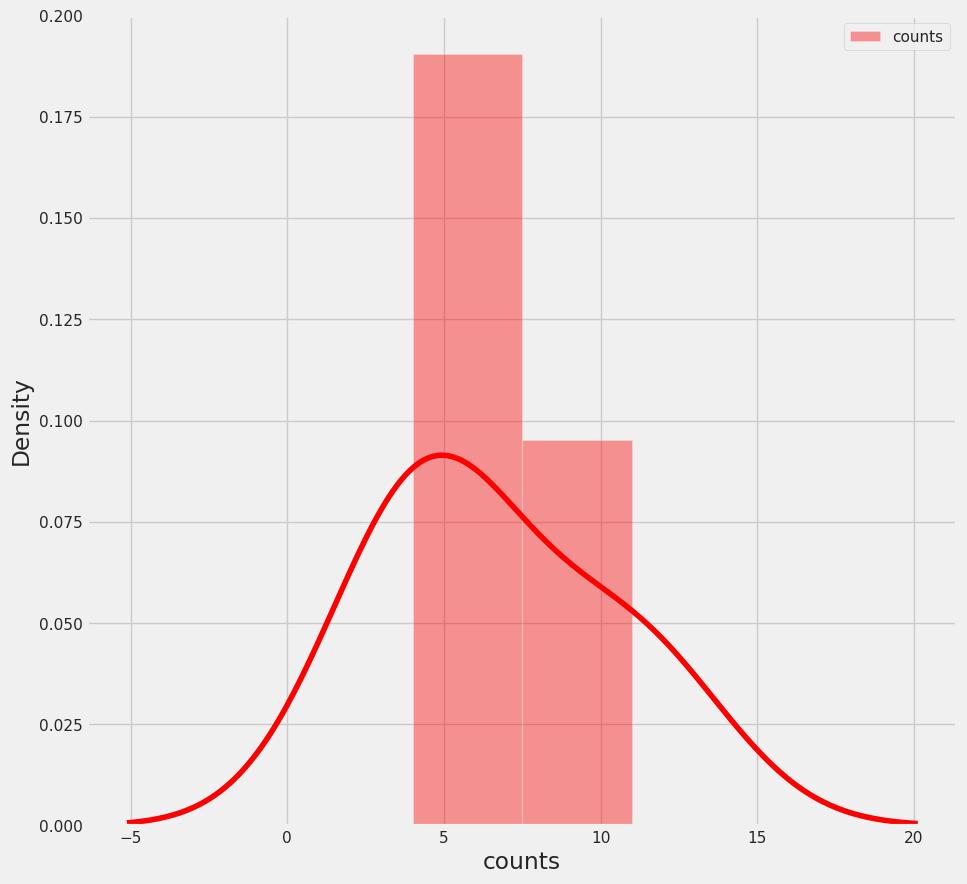

In [35]:
df = hubmap_df.groupby(['race','split'])['race'].count().reset_index(name = 'counts')
plt.figure(figsize=(10,10))
dist(df,"counts","red")


In [36]:
white=hubmap_df[hubmap_df['race']=='White']
black=hubmap_df[hubmap_df['race']=='Black or African American']
count_white=white['split'].value_counts().reset_index()
count_black=black['split'].value_counts().reset_index()
pie_white=go.Pie(labels=count_white['index'],values=count_white['split'],name="White",hole=0.4,domain={'x':[0,0.46]})
pie_black = go.Pie(labels=count_black['index'],values=count_black['split'],name="Black or African American",hole=0.5,domain={'x': [0.52,1]})
layout = dict(title = 'Race', font=dict(size=10), legend=dict(orientation="h"),
              annotations = [dict(x=0.2, y=0.5, text='White', showarrow=False, font=dict(size=20)),
                             dict(x=0.8, y=0.5, text='Black or African American', showarrow=False, font=dict(size=20)) ])
fig=dict(data=[pie_white,pie_black],layout=layout)
pyo.iplot(fig)


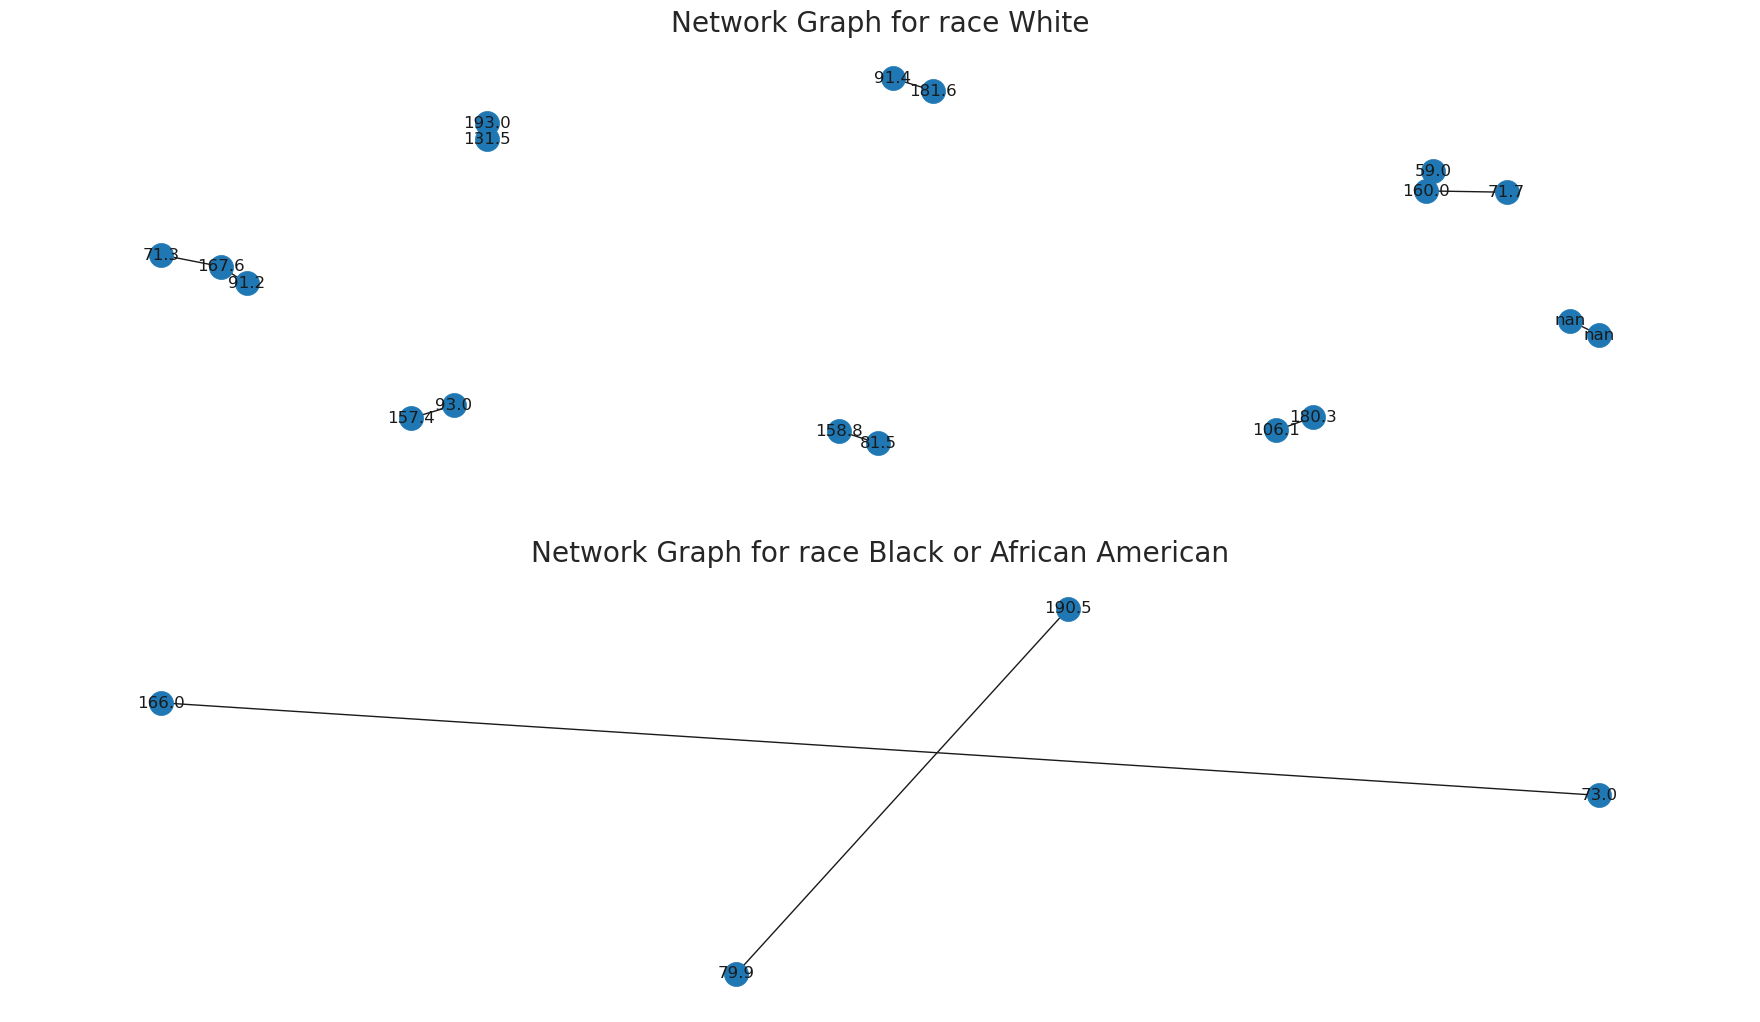

In [37]:
fig,ax=plt.subplots(figsize=(20,12))
for i,t in enumerate(hubmap_df['race'].unique()):
    hubmap_df_type=hubmap_df.loc[hubmap_df['race']==t]
    hubmap_df_type = hubmap_df.loc[hubmap_df['race'] == t]
    bad_weight = list(hubmap_df_type['weight_kilograms'].value_counts(normalize=True)[hubmap_df_type['weight_kilograms'].value_counts(normalize=True) < 0.01].index)
    bad_height = list(hubmap_df_type['height_centimeters'].value_counts(normalize=True)[hubmap_df_type['height_centimeters'].value_counts(normalize=True) < 0.01].index)
    bad_mes=list(set(bad_weight+bad_height))
    hubmap_df_type = hubmap_df_type.loc[(hubmap_df_type['weight_kilograms'].isin(bad_weight) == False) & (hubmap_df_type['height_centimeters'].isin(bad_height) == False)]
    G = nx.from_pandas_edgelist(hubmap_df_type, 'weight_kilograms', 'height_centimeters', ['bmi_kg/m^2'])
    plt.subplot(2, 1, i + 1)
    nx.draw(G, with_labels=True)
    plt.title(f'Network Graph for race {t}')

In [38]:
hubmap_df[['patient_number','split']].value_counts()

patient_number  split
66999           train    2
67026           train    2
67347           train    2
67548           train    2
63921           train    1
65631           train    1
67112           test     1
                train    1
67177           train    1
67347           test     1
68138           test     1
68250           train    1
68304           test     1
                train    1
68555           test     1
                train    1
dtype: int64

In [39]:
hubmap_df[['patient_number','split']].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='red',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the patient_number column in the HuBMAP-20 Set')

In [40]:
df=hubmap_df.groupby(['patient_number','split'])['patient_number'].count().reset_index(name='counts')
df['patient_number_split']=df['patient_number'].astype('str')+'_'+df['split']
fig=px.pie(df,values='counts',names='patient_number_split',title='Patient Number Count')
fig.update_layout(

    autosize=False,
    width=800,
    height=650,
    margin=dict(
    
       l=50,
       r=50, 
       b=50,
       t=50,
       pad=4
    
    
    
    
    ),
    paper_bgcolor="LightSteelBlue",

)
fig.show()

In [41]:
hubmap_df[['ethnicity','split']].value_counts()

ethnicity               split
Not Hispanic or Latino  train    15
                        test      5
dtype: int64

In [42]:
hubmap_df[['ethnicity','split']].value_counts().iplot(kind='bar',yTitle='Counts',linecolor='black',opacity=0.7,color='green',theme='pearl',bargap=0.5,gridcolor='white',title='Distribution of the Ethnicity column in the HuBMAP-20 Set')

In [43]:
df = hubmap_df.groupby(['ethnicity','split'])['ethnicity'].count().reset_index(name = 'counts')
df['ethnicity_split']=df['ethnicity']+'_'+df['split']
fig = px.pie(df, values='counts', names='ethnicity_split', title='Patient Ethnicity Count')
fig.update_layout(
    autosize=False,
    width=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    
    
    
    ),
    paper_bgcolor="LightSteelBlue",
   
)
fig.show()

In [44]:
hubmap_df[['sex','split']].value_counts()

sex     split
Male    train    9
Female  train    6
        test     4
Male    test     1
dtype: int64

In [45]:
hubmap_df[['sex','split']].value_counts().iplot(kind='bar',
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='yellow',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the Sex column in the HuBMAP-20 Set')
                                                



In [46]:
df = hubmap_df.groupby(['sex','split'])['sex'].count().reset_index(name = 'counts')
df['sex_split']=df['sex']+'_'+df['split']
fig = px.pie(df, values='counts', names='sex_split', title='Patient Gender Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",


)
fig.show()

In [47]:
male=hubmap_df[hubmap_df['sex']=='Male']
female=hubmap_df[hubmap_df['sex']== 'Female']
count_male=male['split'].value_counts().reset_index()
count_female=female['split'].value_counts().reset_index()
pie_male=go.Pie(labels=count_male['index'],values=count_male['split'],name="Male",hole=0.4,domain={'x': [0,0.46]})
pie_female = go.Pie(labels=count_female['index'],values=count_female['split'],name="Female",hole=0.5,domain={'x': [0.52,1]})
layout=dict(title='sex',font=dict(size=10),legend=dict(orientation="h"),
           annotations = [dict(x=0.2, y=0.5, text='Male', showarrow=False, font=dict(size=20)),
            dict(x=0.8, y=0.5, text='Female', showarrow=False, font=dict(size=20)) ])

fig=dict(data=[pie_male,pie_female],layout=layout)
pyo.iplot(fig)


In [48]:
hubmap_df[['age','split']].value_counts()

age  split
58   train    4
56   train    3
53   train    2
66   test     2
31   train    1
44   train    1
48   train    1
56   test     1
58   test     1
66   train    1
73   train    1
76   test     1
     train    1
dtype: int64

In [49]:
hubmap_df[['age','split']].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='orange',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the Age column in the HuBMAP-20 Set')

In [50]:
df=hubmap_df.groupby(['age','split'])['age'].count().reset_index(name='counts')
df['age_split']=df['age'].astype('str')+'_'+df['split']
fig=px.pie(df,values='counts',names='age_split', title='Patient Ages Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4

    ),
    paper_bgcolor="LightSteelBlue"
)
fig.show()

In [51]:
hubmap_df[['laterality','split']].value_counts()

laterality  split
Right       train    9
Left        train    6
            test     4
Right       test     1
dtype: int64

In [52]:
hubmap_df[['laterality','split']].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='purple',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the Laterality column in the HuBMAP-20 Set')

In [53]:
df = hubmap_df.groupby(['laterality','split'])['laterality'].count().reset_index(name = 'counts')
df['laterality_split'] = df['laterality']+'_'+df['split']
fig = px.pie(df, values='counts', names='laterality_split', title='Patient Laterality Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [54]:
hubmap_df[['percent_medulla','split']].value_counts()

percent_medulla  split
45               train    5
35               train    4
20               test     3
                 train    3
25               train    3
0                test     1
45               test     1
dtype: int64

In [55]:
hubmap_df[['percent_medulla','split']].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='pink',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the Medulla column in the HuBMAP-20 Set')

In [56]:
df=hubmap_df.groupby(['percent_medulla','split'])['percent_medulla'].count().reset_index(name='counts')
df['percent_medulla_split']=df['percent_medulla'].astype('str')+'_'+df['split']
fg=px.pie(df, values='counts', names='percent_medulla_split', title='Patient Percent_Medulla Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [57]:
hubmap_df[['percent_cortex','split']].value_counts()

percent_cortex  split
55              train    5
65              train    4
75              train    3
80              test     3
                train    3
55              test     1
100             test     1
dtype: int64

In [58]:
hubmap_df[['percent_cortex','split']].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='cyan',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the Medulla column in the HuBMAP-20 Set')

In [59]:
df = hubmap_df.groupby(['percent_cortex','split'])['percent_cortex'].count().reset_index(name = 'counts')
df['percent_cortex_split'] = df['percent_cortex'].astype('str')+'_'+df['split']
fig = px.pie(df, values='counts', names='percent_cortex_split', title='Patient Percent_Cortex Count')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

**Distribution Of Age**

In [60]:
df=hubmap_df
fig=px.violin(df,y='age',x='race',box=True,color='sex',points="all",hover_data=hubmap_df.columns)
fig.show()

Text(0.5, 1.0, 'Distribution of Ages')

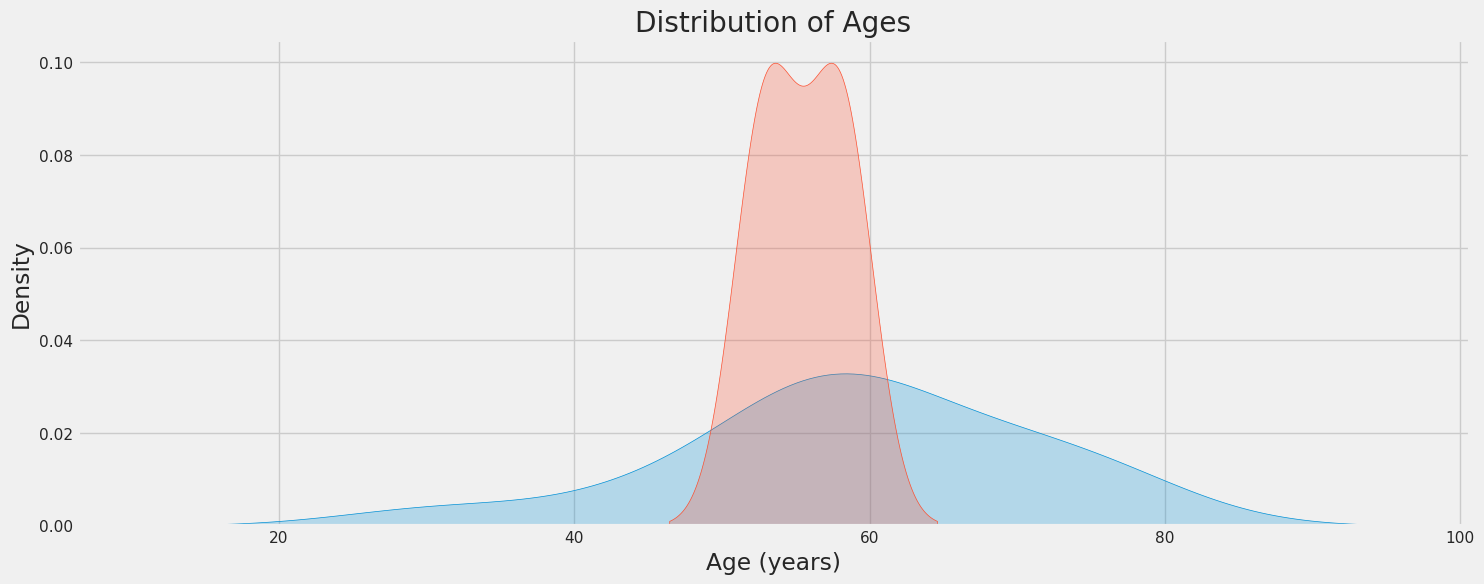

In [61]:
plt.figure(figsize=(16,6))
sns.kdeplot(df.loc[df['race']=='White','age'],label='White',shade=True)
sns.kdeplot(df.loc[df['race'] == 'Black or African American', 'age'], label = 'Black or African American',shade=True)

plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

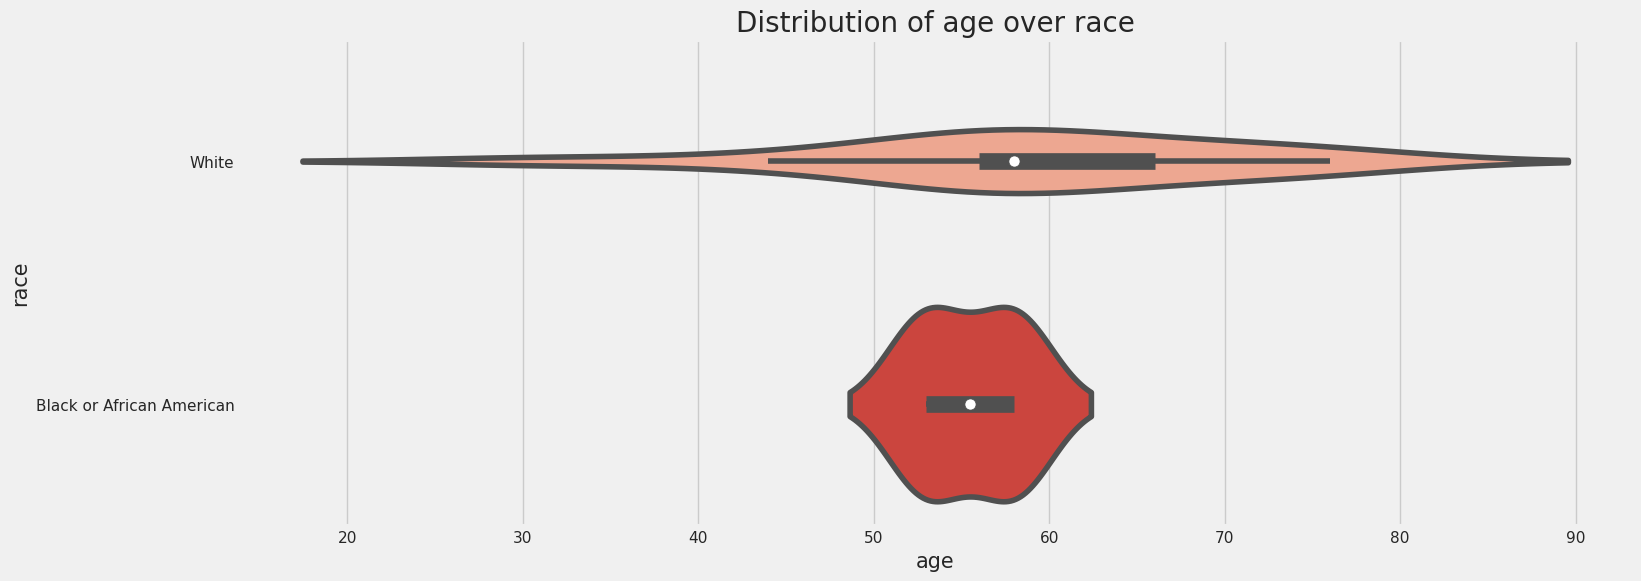

In [62]:
plt.figure(figsize=(16,6))
ax=sns.violinplot(x=df['age'],y=df['race'],palette='Reds')
ax.set_xlabel(xlabel='age',fontsize=15)
ax.set_ylabel(ylabel = 'race', fontsize = 15)
ax.set_title(label = 'Distribution of age over race', fontsize = 20)
plt.show()

In [63]:
df=hubmap_df.groupby(['age','race'])['age'].count().reset_index(name='counts')
df['age_race']=df['age'].astype('str')+'_'+df['race']
fig = px.pie(df, values='counts', names='age_race', title='Distribution Of Age Over Race')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

**Distribution of race**

In [64]:
df = hubmap_df
fig=px.violin(df,x='race',y='percent_medulla',box=True,color='sex',points='all',hover_data=hubmap_df.columns)
fig.show()

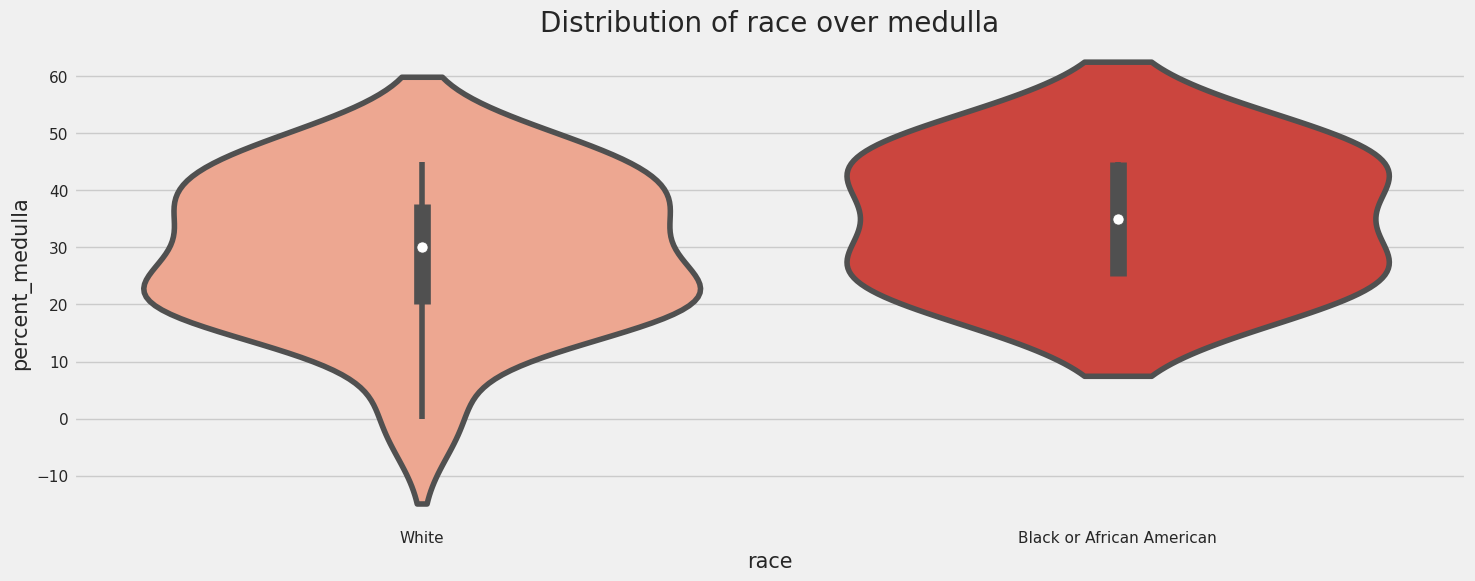

In [65]:
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x = df['race'], y = df['percent_medulla'], palette = 'Reds')
ax.set_xlabel(xlabel = 'race', fontsize = 15)
ax.set_ylabel(ylabel = 'percent_medulla', fontsize = 15)
ax.set_title(label = 'Distribution of race over medulla', fontsize = 20)
plt.show()

In [66]:
df = hubmap_df.groupby(['race','percent_medulla'])['race'].count().reset_index(name = 'counts')
df['race_percent_medulla'] = df['race']+'_'+df['percent_medulla'].astype('str')
fig = px.pie(df, values='counts', names='race_percent_medulla', title='Distribution Of Race Over Percent Medulla')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

**Distiribution of age over percent medulla**

Text(0.5, 1.0, 'Distribution of Ages')

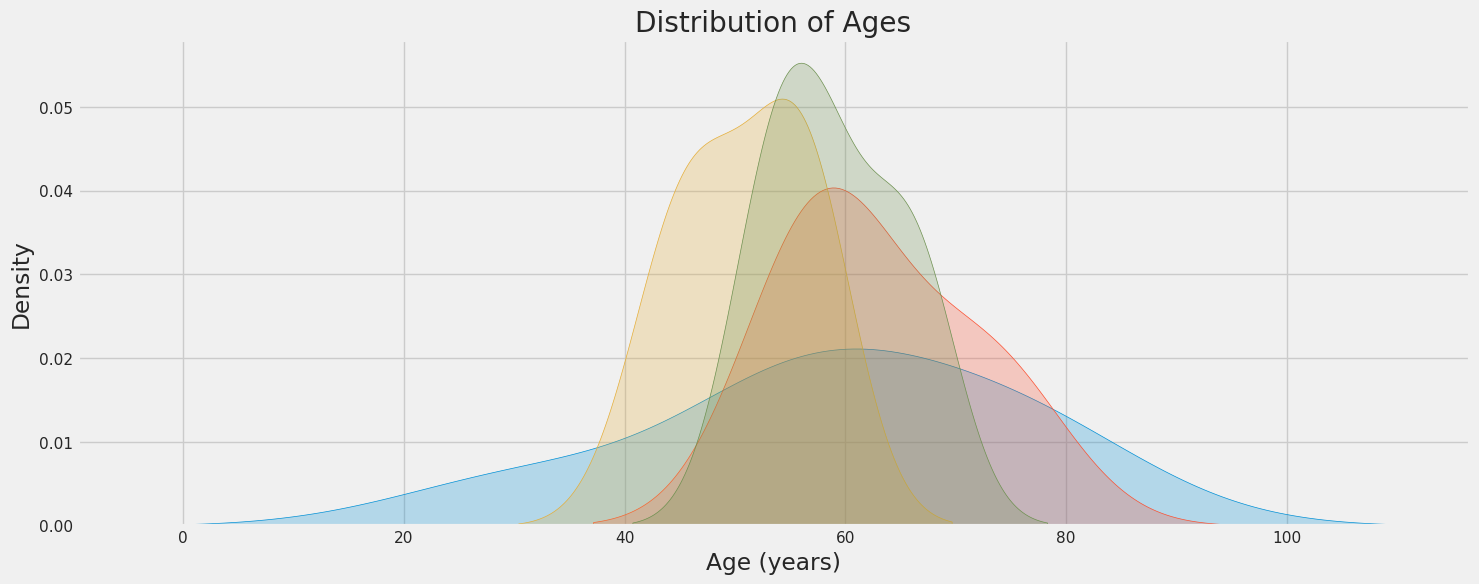

In [67]:
df=hubmap_df
plt.figure(figsize=(16, 6))
sns.kdeplot(df.loc[df['percent_medulla']==20,'age'],label=20,shade=True)
sns.kdeplot(df.loc[df['percent_medulla'] == 25, 'age'], label = 25,shade=True)
sns.kdeplot(df.loc[df['percent_medulla'] == 35, 'age'], label = 35,shade=True)
sns.kdeplot(df.loc[df['percent_medulla'] == 45, 'age'], label = 45,shade=True)

plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

In [68]:
df = hubmap_df.groupby(['age','percent_medulla'])['age'].count().reset_index(name = 'counts')
df['age_percent_medulla'] = df['age'].astype('str')+'_'+df['percent_medulla'].astype('str')
fig = px.pie(df, values='counts', names='age_percent_medulla', title='Distribution Of Age Over Percent Medulla')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

Text(0.5, 1.0, 'Distribution of Ages')

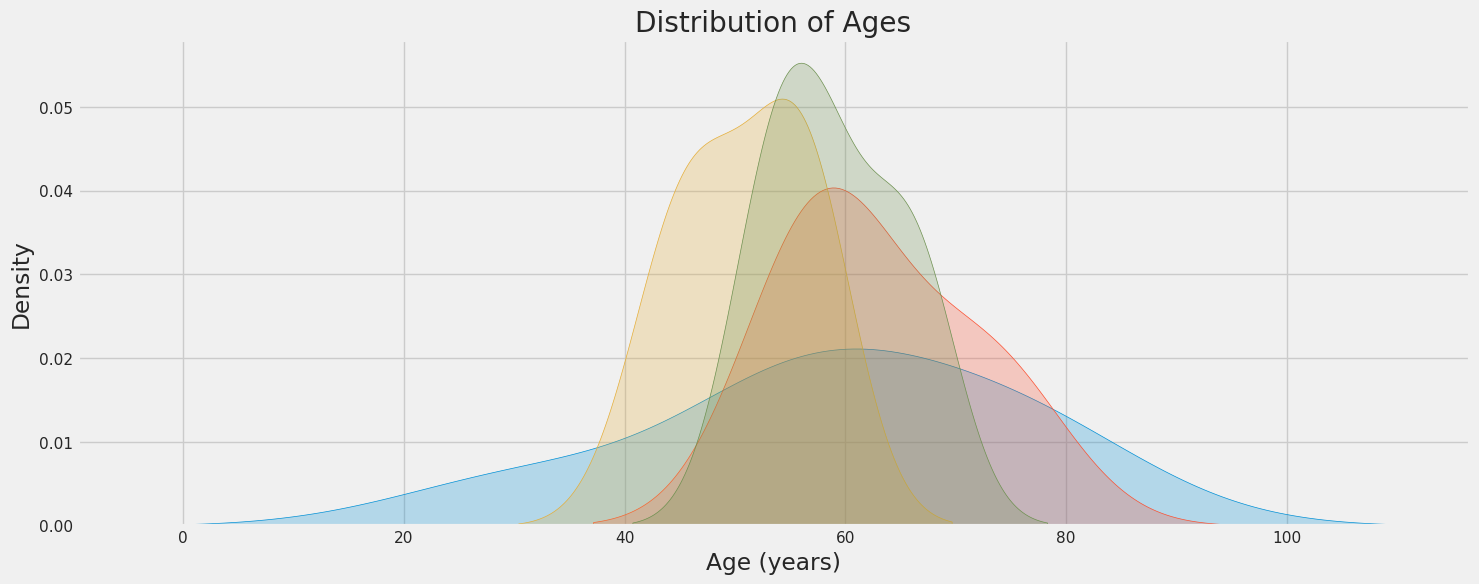

In [69]:
df = hubmap_df
plt.figure(figsize=(16, 6))
sns.kdeplot(df.loc[df['percent_cortex'] == 80, 'age'], label = 20,shade=True)
sns.kdeplot(df.loc[df['percent_cortex'] == 75, 'age'], label = 25,shade=True)
sns.kdeplot(df.loc[df['percent_cortex'] == 65, 'age'], label = 35,shade=True)
sns.kdeplot(df.loc[df['percent_cortex'] == 55, 'age'], label = 45,shade=True)


# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

In [70]:
df=hubmap_df.groupby(['age','percent_cortex'])['age'].count().reset_index(name='counts')
df['age_percent_cortex'] = df['age'].astype('str')+'_'+df['percent_cortex'].astype('str')
fig = px.pie(df, values='counts', names='age_percent_cortex', title='Distribution Of Age Over Percent Cortex')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [71]:
(hubmap_df['percent_medulla']+hubmap_df['percent_cortex']).unique()

array([100])

**Sex and Race**

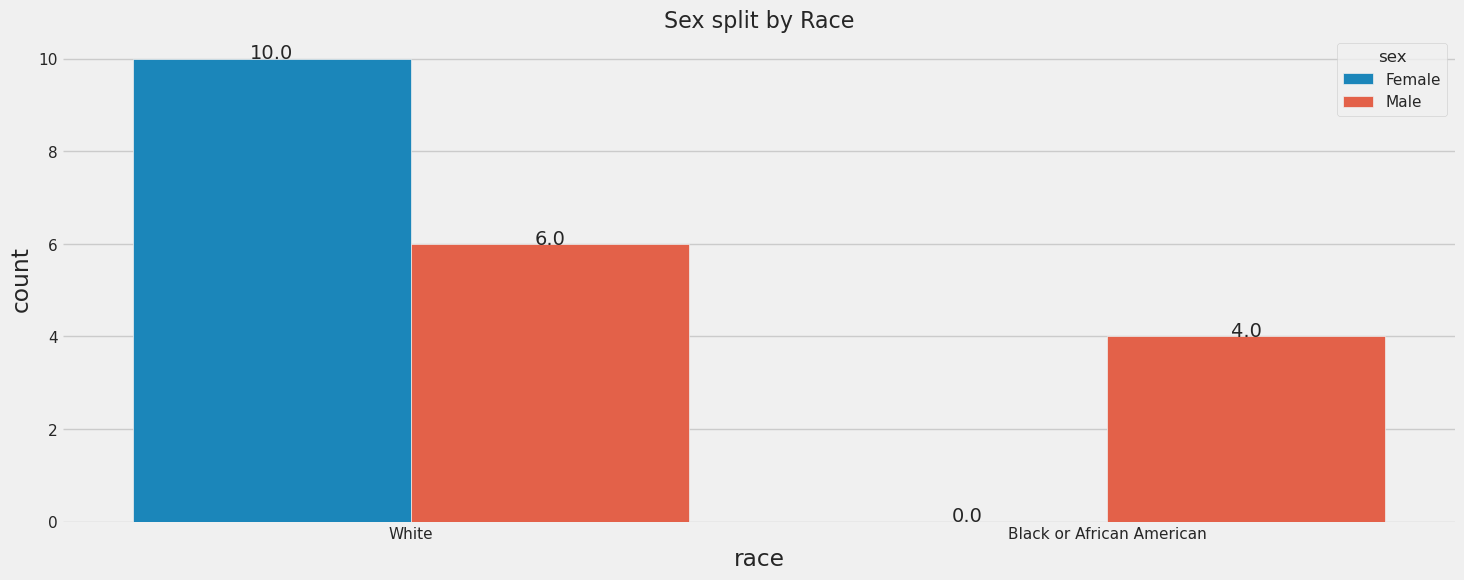

In [72]:
plt.figure(figsize=(16, 6))
a=sns.countplot(data=hubmap_df,x='race',hue='sex')

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

plt.title('Sex split by Race', fontsize=16)
sns.despine(left=True, bottom=True)

In [73]:
fig = px.box(hubmap_df, x="sex", y="age", points="all")
fig.show()

In [74]:
df = hubmap_df.groupby(['sex','race'])['sex'].count().reset_index(name = 'counts')
df['sex_race'] = df['sex'].astype('str')+'_'+df['race'].astype('str')
fig = px.pie(df, values='counts', names='sex_race', title='Sex Versus Race')
fig.update_layout(
    autosize=False,
    width=800,
    height=650,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [75]:
male = hubmap_df[hubmap_df['sex']=='Male']
female = hubmap_df[hubmap_df['sex']== 'Female']
count_male = male[['race','split']].value_counts().reset_index()
count_female = female[['race','split']].value_counts().reset_index()
pie_male = go.Pie(labels=count_male[['race','split']],values=count_male[0],name="Male",hole=0.4,domain={'x': [0,0.46]})
pie_female = go.Pie(labels=count_female[['race','split']],values=count_female[0],name="Female",hole=0.5,domain={'x': [0.52,1]})
layout = dict(title = 'Sex_Race', font=dict(size=10), legend=dict(orientation="h"),
              annotations = [dict(x=0.2, y=0.5, text='Male', showarrow=False, font=dict(size=20)),
                             dict(x=0.8, y=0.5, text='Female', showarrow=False, font=dict(size=20)) ])

fig = dict(data=[pie_male, pie_female], layout=layout)
pyo.iplot(fig)

In [76]:
male = hubmap_df[hubmap_df['sex']=='Male']
female = hubmap_df[hubmap_df['sex']== 'Female']
count_male = male['race'].value_counts().reset_index()
count_female = female['race'].value_counts().reset_index()
pie_male = go.Pie(labels=count_male['index'],values=count_male['race'],name="Male",hole=0.4,domain={'x': [0,0.46]})
pie_female = go.Pie(labels=count_female['index'],values=count_female['race'],name="Female",hole=0.5,domain={'x': [0.52,1]})
layout = dict(title = 'Sex_Race', font=dict(size=10), legend=dict(orientation="h"),
              annotations = [dict(x=0.2, y=0.5, text='Male', showarrow=False, font=dict(size=20)),
                             dict(x=0.8, y=0.5, text='Female', showarrow=False, font=dict(size=20)) ])

fig = dict(data=[pie_male, pie_female], layout=layout)
pyo.iplot(fig)

**HeatMap**

<Axes: >

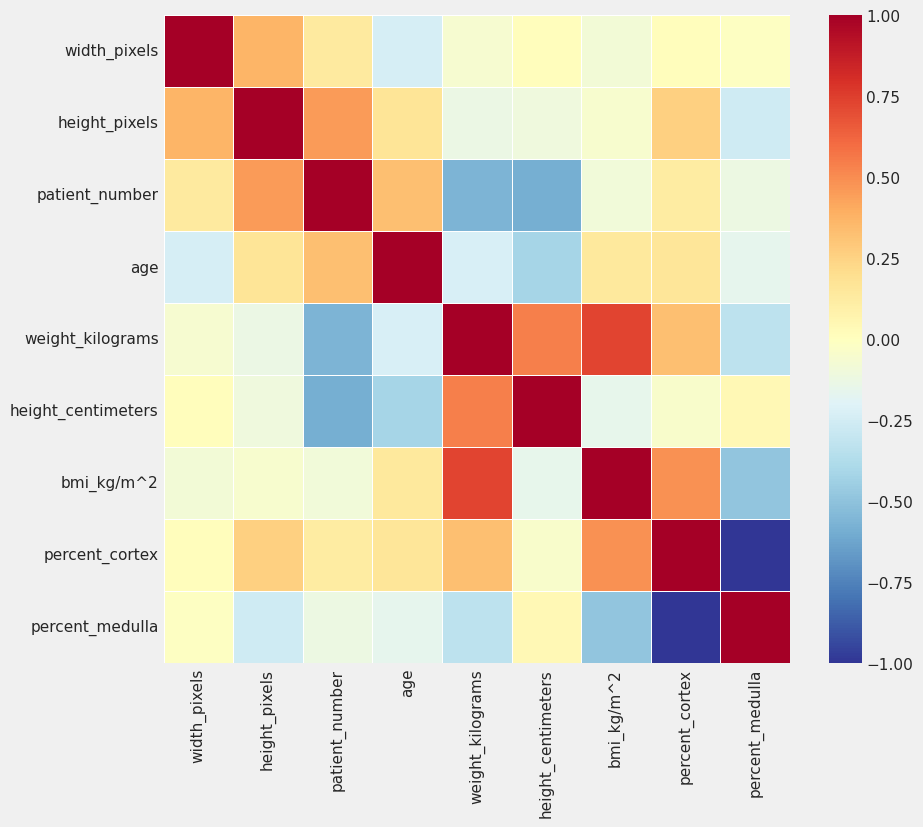

In [77]:
corrmat=hubmap_df.corr()
f,ax=plt.subplots(figsize=(9,8))
sns.heatmap(corrmat,ax=ax,cmap='RdYlBu_r',linewidths = 0.5)

In [78]:
print(Fore.YELLOW + 'Train .tiff number of images:',Style.RESET_ALL, len(list(os.listdir('../input/hubmap-kidney-segmentation/train')))/3, '\n' +
      Fore.BLUE + 'Test .tiff number of images:',Style.RESET_ALL, len(list(os.listdir('../input/hubmap-kidney-segmentation/test')))/2)

Train .tiff number of images:  15.0 
Test .tiff number of images:  5.5


In [79]:
IMAGE_PATH = '../input/hubmap-kidney-segmentation'
os.path.join(IMAGE_PATH, 'train/095bf7a1f.tiff')

'../input/hubmap-kidney-segmentation/train/095bf7a1f.tiff'

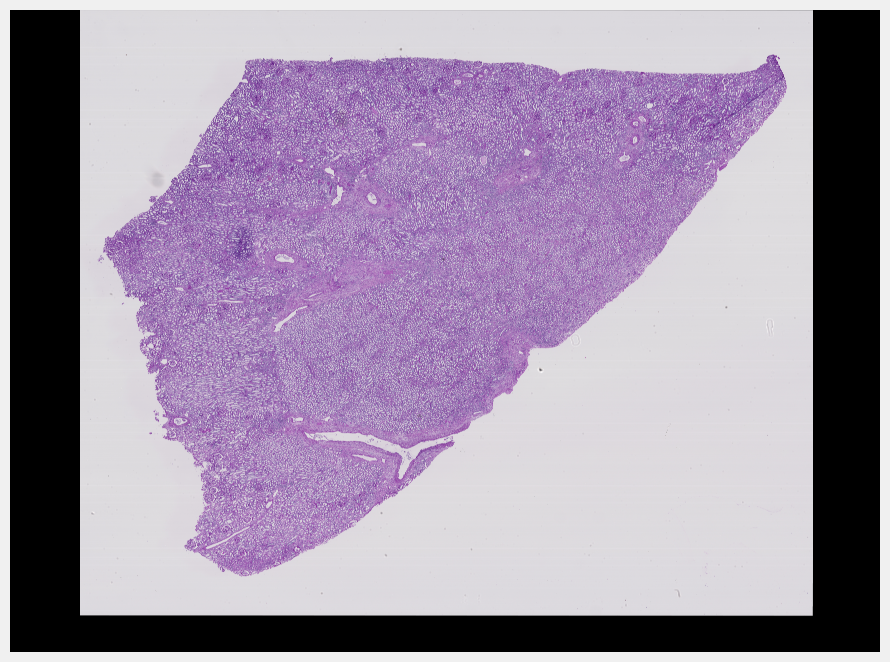

In [80]:
im=tiff.imread(

    os.path.join(IMAGE_PATH,"train/0486052bb.tiff")
)
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.axis("off")
del im